## Part 1. Gaussian quadrature

The Gaussian quadrature method is one of the methods of numerical integration that allows you to increase the accuracy of integration, by using orthogonal polynomials and their roots as nodes.

$$
\int_a^b \!  w(x)\, f(x)\, dx \approx \sum_{k=1}^n w_k \, f(x_k) \;,
$$

here $\omega$ is the weight function, this weight function determines the basis of orthogonal polynomials whose roots are used as integration nodes. If the function $f(x)$ is a polynomial, then such an integration method gives *exact* value for the integral.

For example, let's calculate the following integral:
$$
\int_{-1}^1 (7x^3 - 8 x^2 - 3 x + 3) dx  \label{eq1}\tag{1}
$$

Here function is already polynomial, so we put the weight function $\omega(x) = 1$. Then the calculation of the integral reduces to the sum in the polynomials roots witch corresponding to the weight function $\omega(x) = 1$. For example, here https://dlmf.nist.gov/18.3 you may see which basis of polynomials corresponds to your weight function.

You may see, that Legendre polynomials correspond to our weight function. Now go to the documentation https://docs.scipy.org/doc/scipy/reference/special.html#orthogonal-polynomials. Here, the function *roots_legendre* immediately gives you the roots of the Legendre polynomial and weight at this roots (for Legendre polynomials all these weight are ones).


### Task 1.1
(20% of the grade)

1. Calculate the exact value of the integral ([1](#mjx-eqn-eq1)) using a pen and paper (or in your mind). Remember it, then you will compare numerical results with it.

In [1]:
2/3

0.6666666666666666

2. Calculate the value of the integral ([1](#mjx-eqn-eq1)) using the usual method of numerical integration on a uniform grid (for example, implemented by you in week_6_calculus homework). Estimate the number of nodes needed to achieve relative accuracy $10^{-10}$.

In [2]:
import numpy as np

def midpoint_rule(func, a, b, eps):
    N = 1
    I_ = float('inf')
    while True:
        h = (b - a) / N
        Q = np.asarray([h * func(a + k * h - h / 2) for k in range(1, N + 1)])
        I = np.sum(Q)
        err = np.abs(I - I_)
        if err >= eps:
            N = 2 * N
            I_ = I
        else:
            break
    return I, N

In [3]:
def func(x):
    return 7 * x **3 - 8 * x ** 2 - 3 * x + 3

I, N = midpoint_rule(func, -1, 1, 1e-10)
print(I, N)

0.6666666666860692 524288


3. Calculate the integral ([1](#mjx-eqn-eq1)) using the roots of the Legendre polynomial from 1 to 6 degrees as nodes (to get roots and weigths use scipy.special.roots_legendre)

In [5]:
from scipy.special import roots_legendre

for n in range(1, 10):
    nodes, weights = roots_legendre(n, mu=False)
    N = nodes.shape[0]
    I = weights @ func(nodes)
    print(I, N)

6.0 1
0.6666666666666674 2
0.6666666666666639 3
0.6666666666666667 4
0.6666666666666685 5
0.6666666666666692 6
0.6666666666666636 7
0.6666666666666722 8
0.6666666666666683 9


Compare the number of nodes needed to obtain the same accuracy in both numerical methods.

Очень близкое значение уже при n~2

### Task 1.2
(20% of the grade)

Calculate the value of the same integral, but on the interval from 0 to 10.
$$
\int_{0}^{10} (7x^3 - 8 x^2 - 3 x + 3) dx 
$$

Please note that you can no longer directly use Legendre polynomials, because they are defined for the interval (-1,1). But you can always make an *affine transformation* (a transformation that does not change the area) in order to go to the desired coordinate system.

In [12]:
def func(x):
    return 7 * 10000 * x ** 3 - 8 * 1000 * x ** 2 - 3 * 100 * x + 3 * 10

for n in range(1, 10):
    nodes, weights = roots_legendre(n, mu=False)
    N = nodes.shape[0]
    I = weights / 2 @ func((nodes + 1) / 2) 
    print(I, N)

6630.0 1
14713.333333333332 2
14713.333333333332 3
14713.333333333328 4
14713.333333333328 5
14713.333333333332 6
14713.333333333336 7
14713.333333333325 8
14713.333333333328 9


14713.(3) Истинное значение

Очень близкие значения

### Task 1.3
(20% of the grade)

Calculate the value of the following integral:
$$
\int_{0}^{2\pi} \frac{cos(x) dx }{\sqrt{4\pi^2 - x^2}}
$$
by using the corresponding basis of orthogonal polynomials. 
Find the degree of the polynomial (number of nodes) at which the accuracy of the integral starts to exceed the double floating point accuracy.

In [7]:
from scipy.special import roots_chebyt

def func(x):
    return np.cos(2 * np.pi * x) / 2

N = 1
I0 = float('inf')

while True:
    nodes, weights = roots_chebyt(N, mu=False)
    I = weights @ func(nodes) 
    err = np.abs(I - I0)
    if err >= 1e-16:
            N += 1
            I0 = I
    else:
        break

print(I, N)

0.34601015881226416 16


## Part 2. Fredholm equation

There are two types of Fredholm equations. 

1. Fredholm equation of the first kind:
$$
\int_a^b \! K(x, t)\, \color{blue}{f(t)} \,dt = g(x)
$$

2. Fredholm equation of the second kind:
$$
\lambda \int_a^b\! K(x, t)\, \color{blue}{f(t)} \, dt + g(x) = \color{blue}{f(x)}
$$

Here higtlighted function $f(x)$ is unknown, kernel function $K(x, t)$ and given function $g(x)$, $\lambda$ is a real number. Numerically, Fredholm equations of the first kind are very ill-conditioned. We will consider equations of the second kind only.

The basic idea is to approximate the integral by some quadrature formula

$$
\int_a^b \! \xi(t)\, dt \approx \sum_j^N w_j\, \xi(t_j)
$$

with appropriate weights $w_j$ and nodes $t_j$ and $j=1, \dots, N$. The accuracy of the approximation is controlled by $N$.

This way, the FE is approximated by 

$$
\lambda \sum_j w_j\, K(x, t_j)\, \color{blue}{f(t_j)} + g(x) = \color{blue}{f(x)}
$$

Note that here $x$ is a continuous variable, and we only discretized $t$.


Evaluating this equation on the grid $x = t_k$, we obtain

$$
\lambda \sum_j w_j \, K_{k, j}\, \color{blue}{f_j} + g_k = \color{blue}{f_k}
$$

where $f_j \equiv f(t_j)$, $g_j \equiv g(t_j)$ and $K_{k, j} \equiv K(t_k, t_j)$. This is nothing but a system of linear algebraic equations for the vector of $\color{blue}{f_j}$.

Its solution gives the values of the unknown function $f(x)$ at the discrete values $x=t_j$ for $j=1, \dots, N$.

### Task 2.1
(20% of the grade)

Solve an example Fredholm equation of the second kind

$$
f(x) = \sin(\pi x)  + \frac{1}{2} \int_0^1\! f(t) \, dt
$$

Here $a, b = 0, 1$, $\lambda = \dfrac{1}{2}$, the kernel is $K(x, t) = 1$ and the right-hand side $g(x) = \sin(\pi x)$.

In fact, the exact solution is (В. А. Попов, Сборник задач по интегральным уравнениям, 2006, стр. 5)

$$
f(x) = \sin(\pi x) + \frac{2}{\pi}
$$

For the integral, we can use a Gaussian quadrature with the weight function $w(x) = 1$ on $(0, 1)$. Looking at http://dlmf.nist.gov/18.3, and find the corresponding function in *scipy.special* (pay attention to the integration interval).

Compare the obtained function values with the true solution for different values of $N$. What value of $N$ can you stop at?

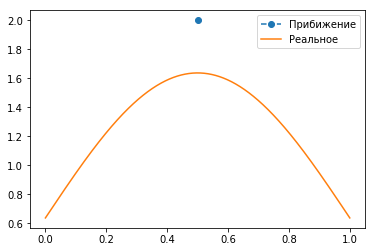

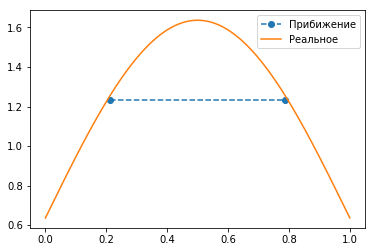

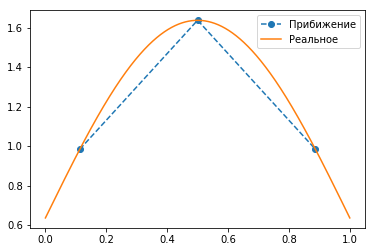

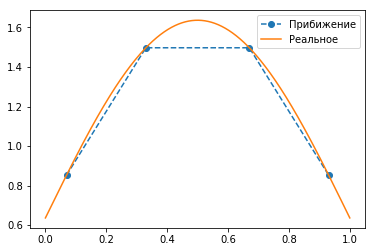

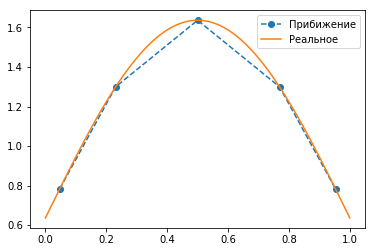

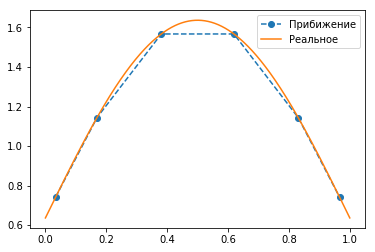

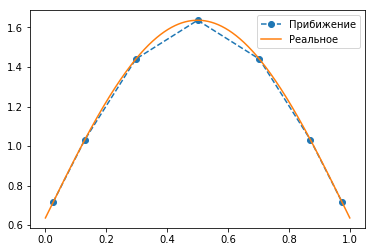

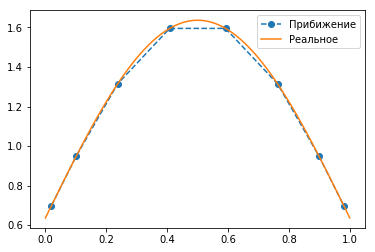

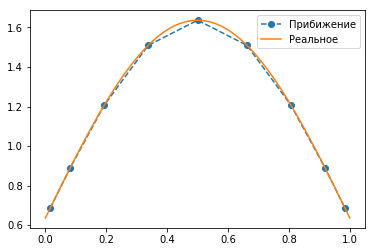

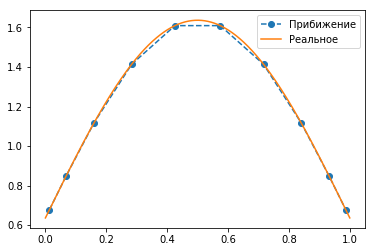

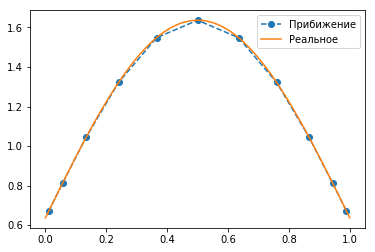

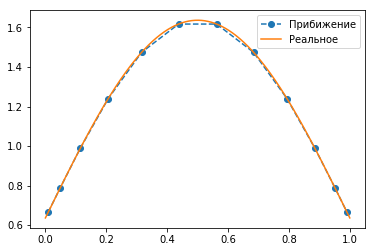

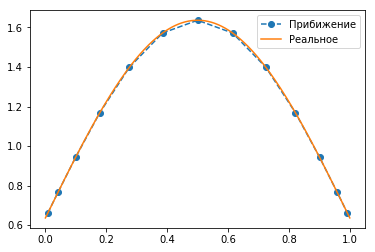

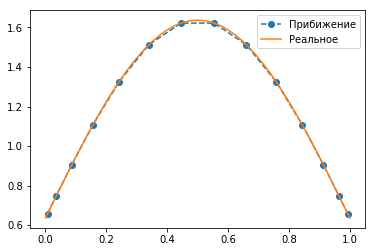

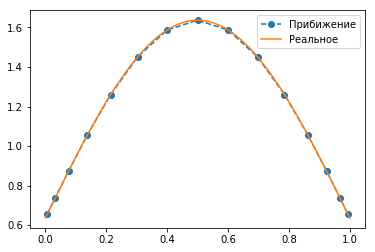

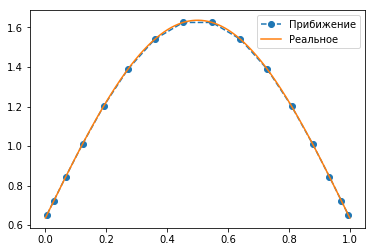

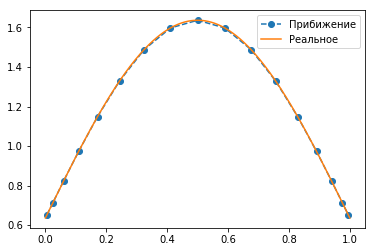

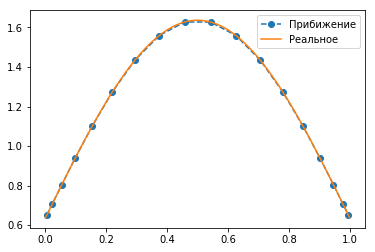

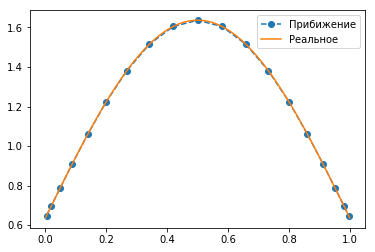

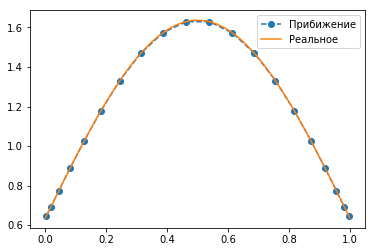

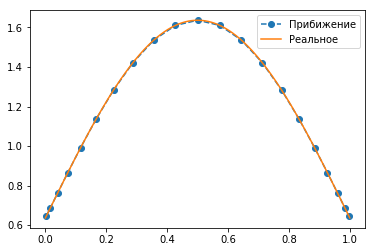

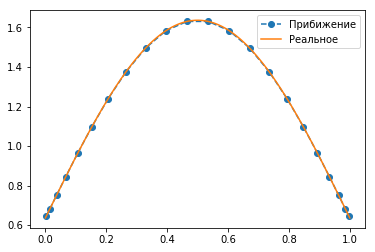

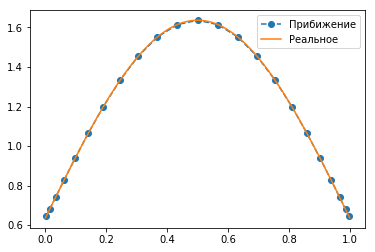

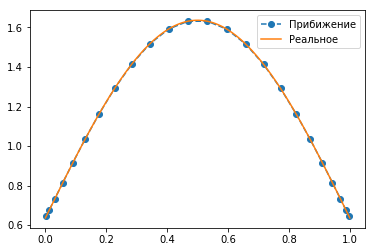

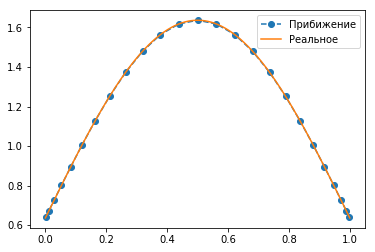

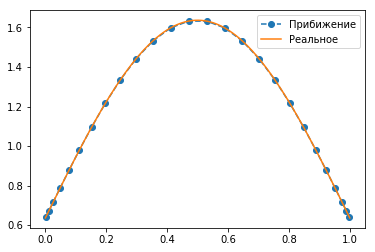

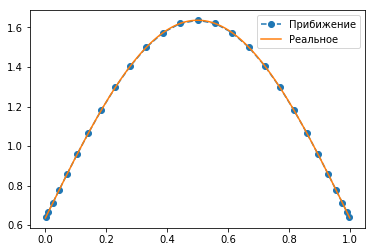

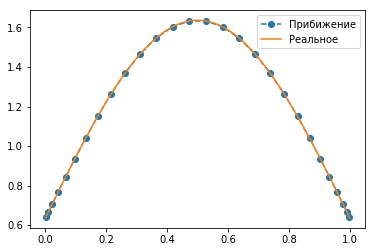

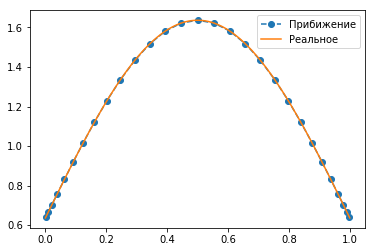

In [13]:
import matplotlib.pyplot as plt

def fredholm_ex(n):
    nodes, weights = roots_legendre(n, mu=False)
    N = nodes.shape[0]
    A = np.tile(weights / 2, (N, 1)) - 2 * np.eye(N)
    b = - 2 * np.sin(np.pi * (nodes + 1) / 2)
    f = np.linalg.solve(A, b)
    return f, (nodes + 1) / 2, weights / 2

for n in range(1, 30):
    f_n, x_n, w_n = fredholm_ex(n)
    x = np.linspace(0.0, 1.0, 10 ** 4)
    plt.plot(x_n, f_n, 'o--', label='Прибижение')
    plt.plot(x, np.sin(np.pi * x) + 2 / np.pi, '-', label='Реальное')
    plt.legend(loc='best')
    plt.show()


### Task 2.2
(20% of the grade)

An obvious issue with the privious result for $f(x)$ that it returns the solution on a fixed set of points. We do not control precise positions of these points.

1. First, let's try to interpolate the values obtained in the previous task to a uniform grid of length 50. You may use any interpolation method. Compare the interpolation values with exact solution values.

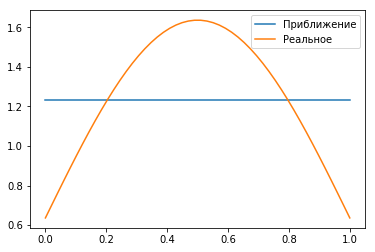

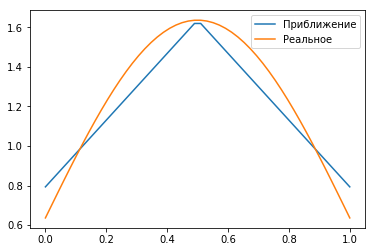

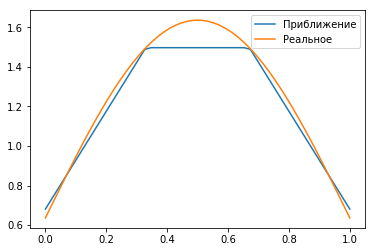

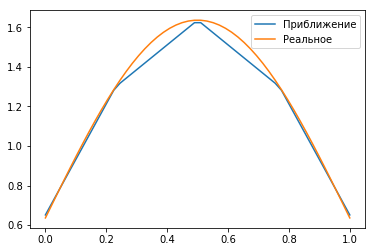

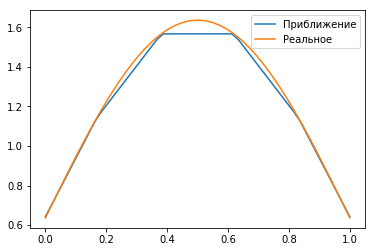

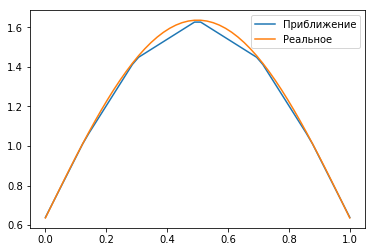

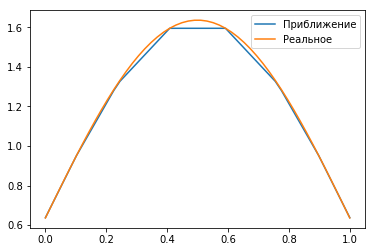

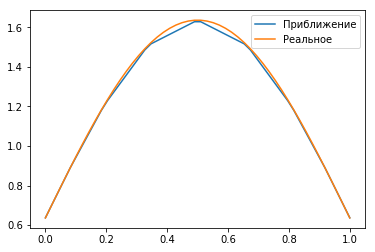

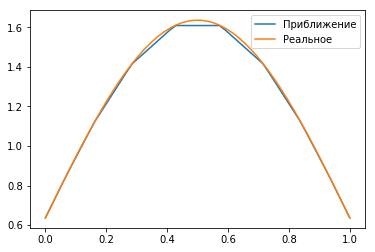

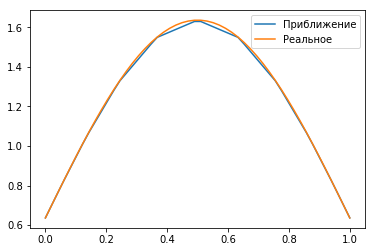

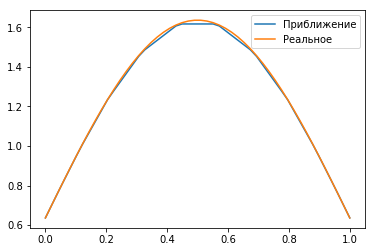

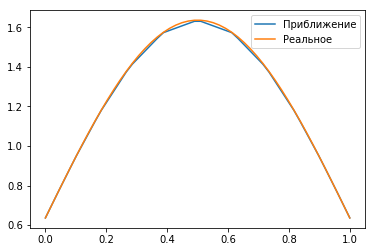

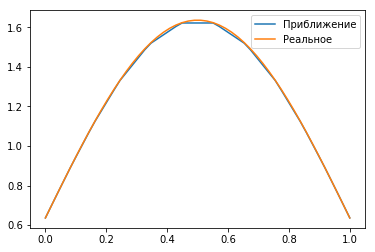

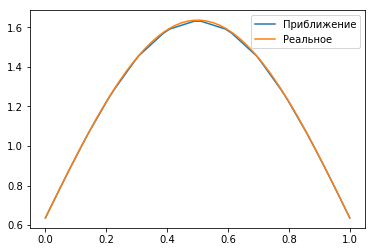

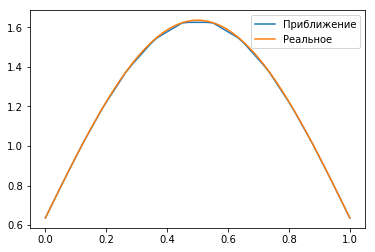

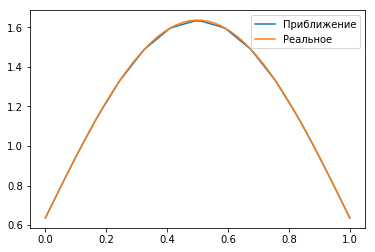

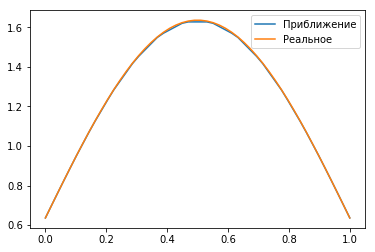

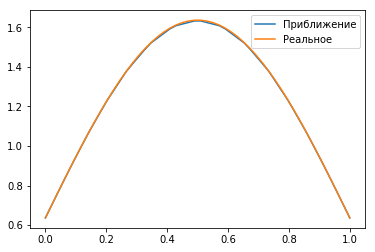

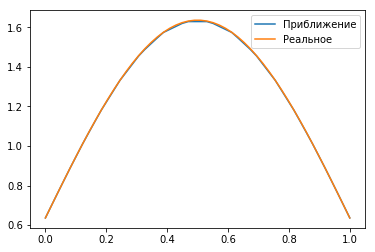

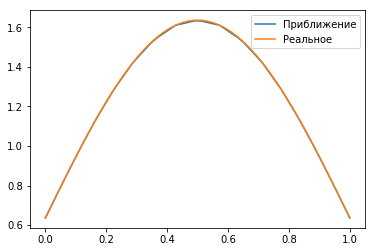

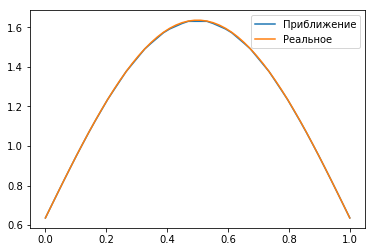

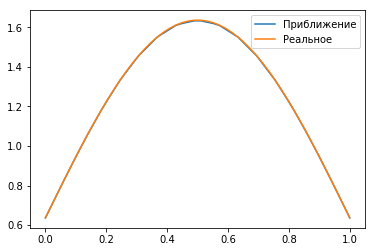

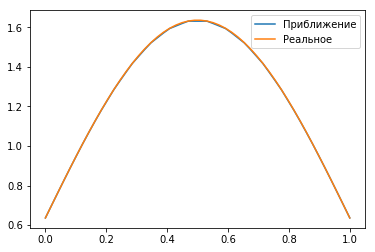

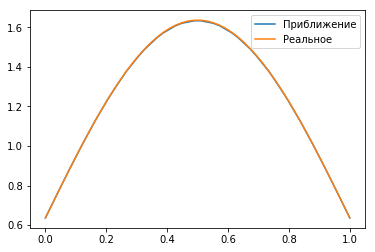

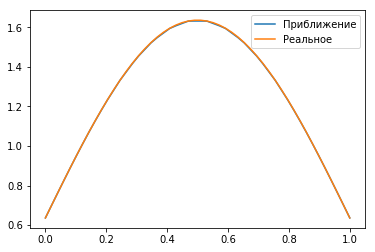

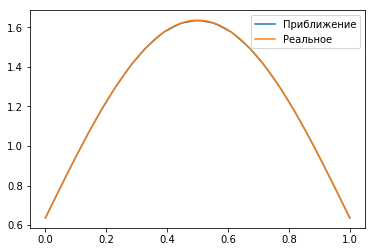

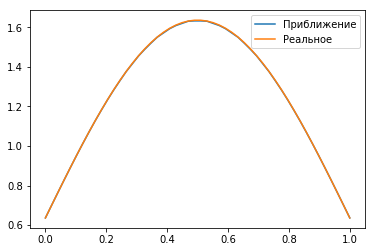

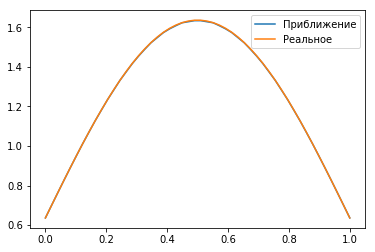

In [14]:
from scipy.interpolate import interp1d

for n in range(2, 30):
    f_n, x_n, w_n = fredholm_ex(n)
    f = interp1d(x_n, f_n, fill_value="extrapolate")
    x = np.linspace(0, 1, 50)
    plt.plot(x, f(x), '-', label='Приближение')
    plt.plot(x, np.sin(np.pi * x) + 2 / np.pi, '-', label='Реальное')
    plt.legend(loc='best')
    plt.show()

2. Now use the following formula to calculate the function at points of the same uniform grid.
$$
f(x) = g(x) + \lambda \sum_j^N w_j\, K(x, t_j)\, f(t_j)
$$
Again, compare the interpolation values with the exact solution values, and also with the direct interpolation method.

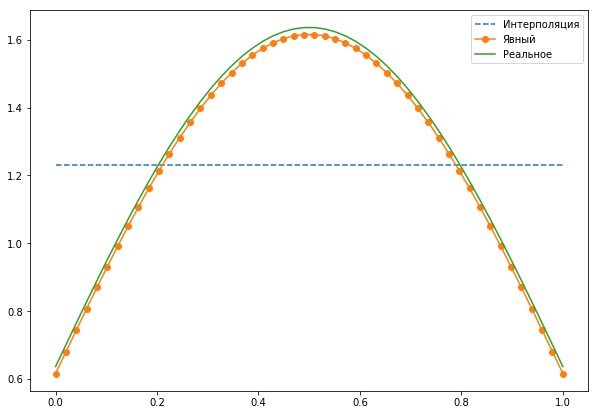

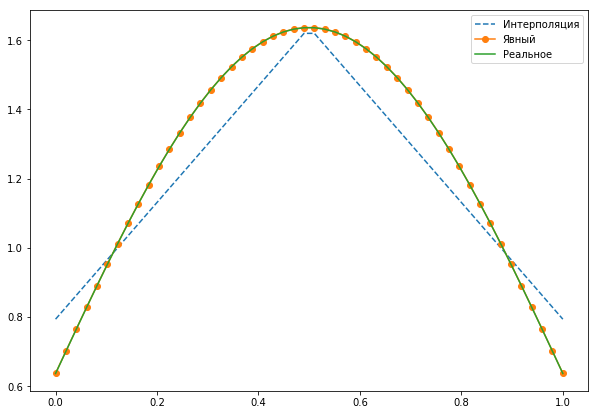

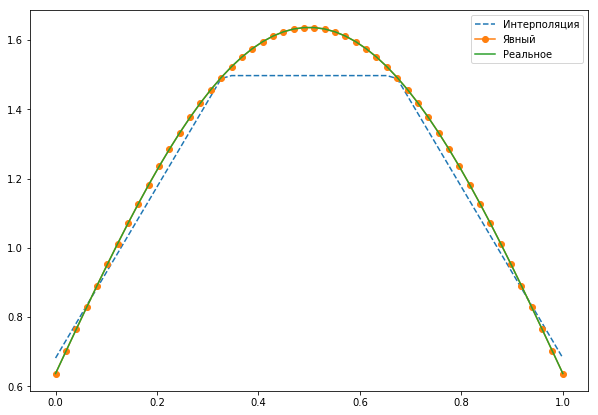

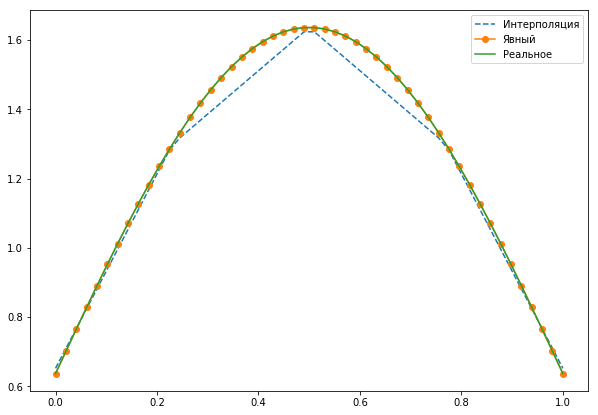

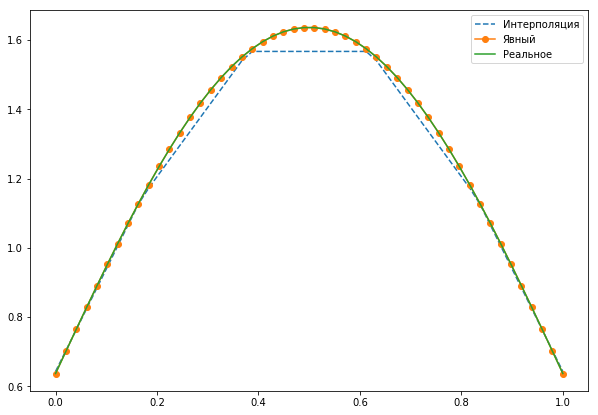

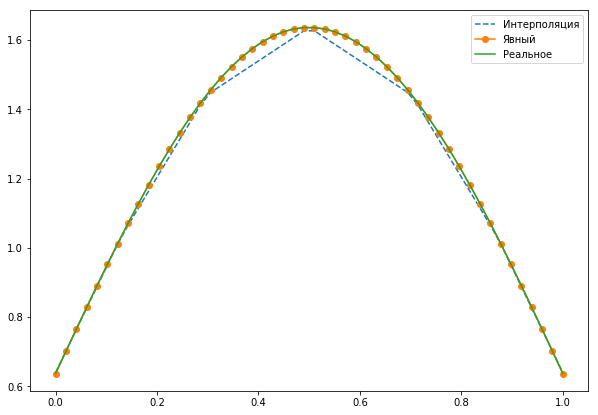

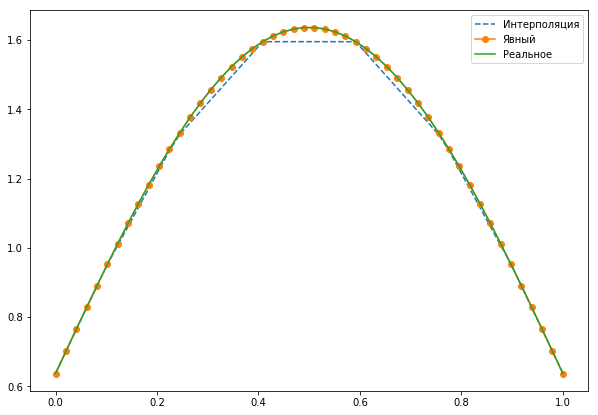

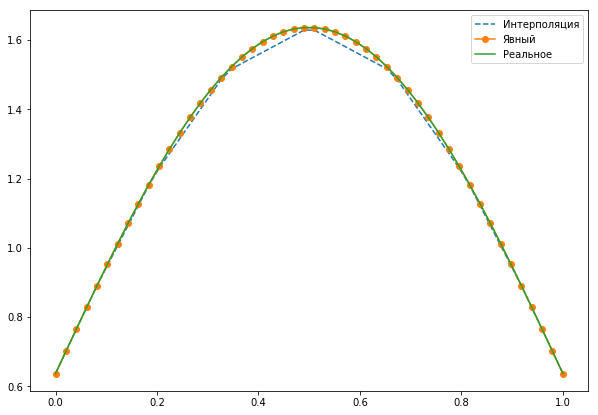

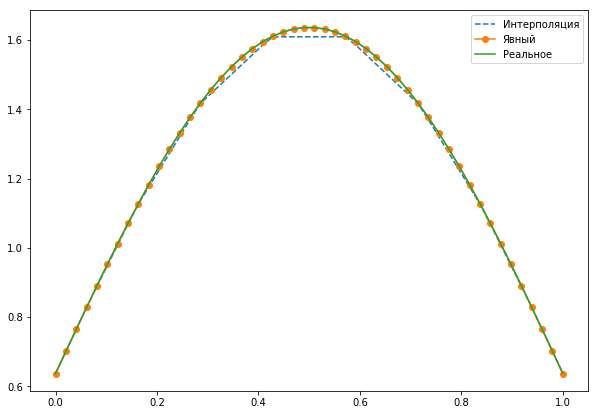

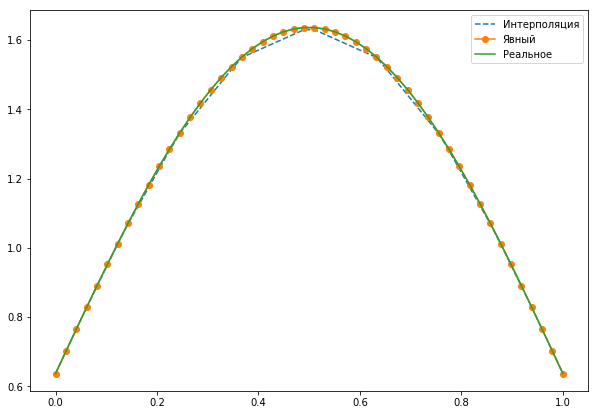

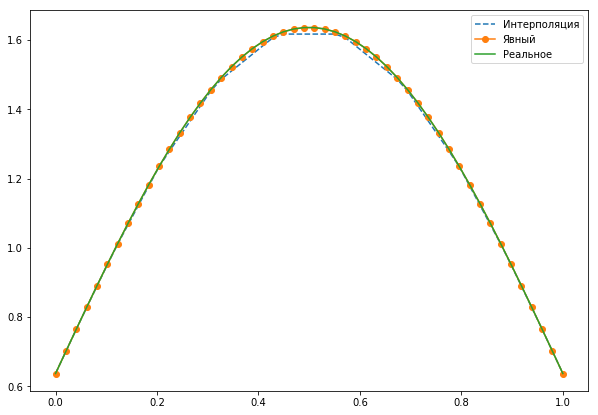

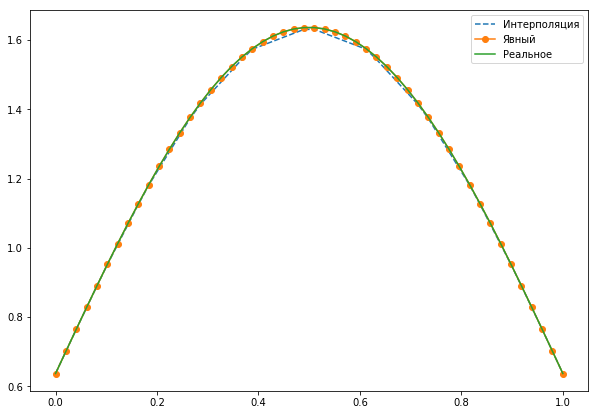

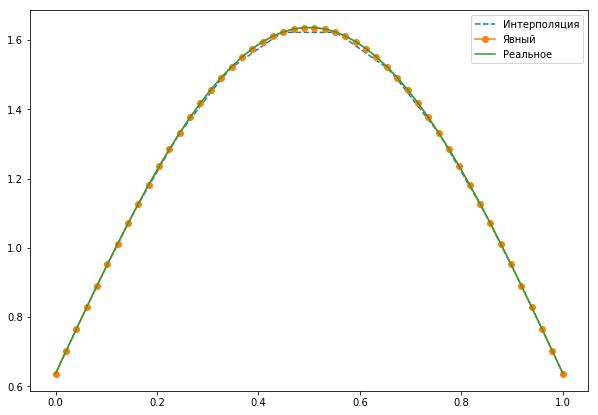

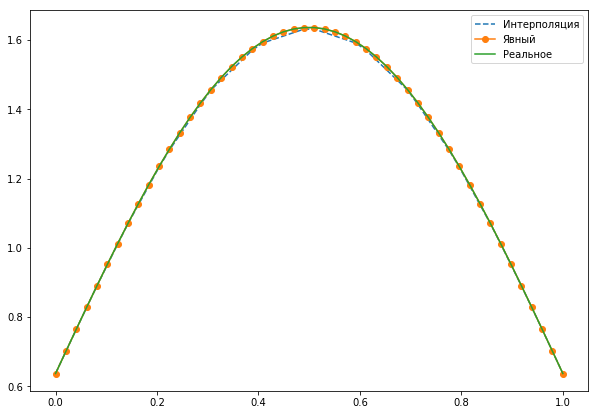

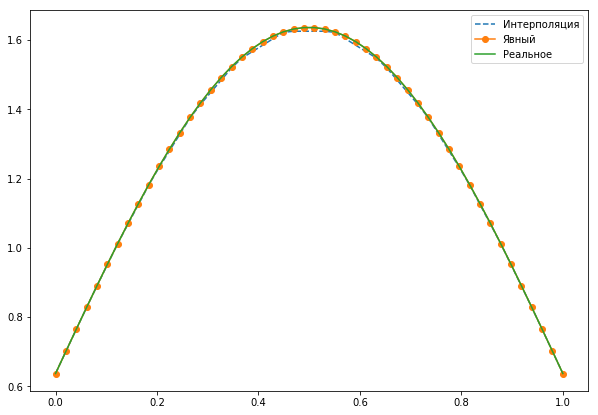

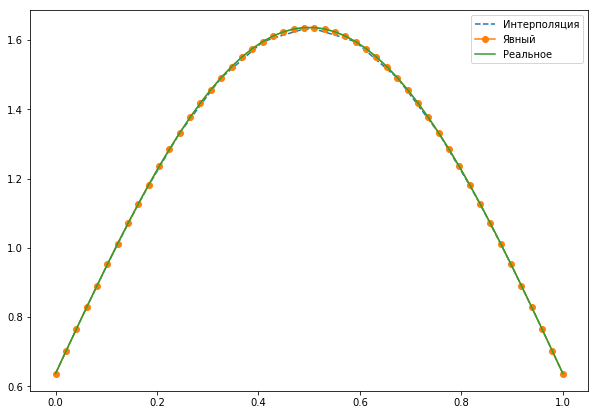

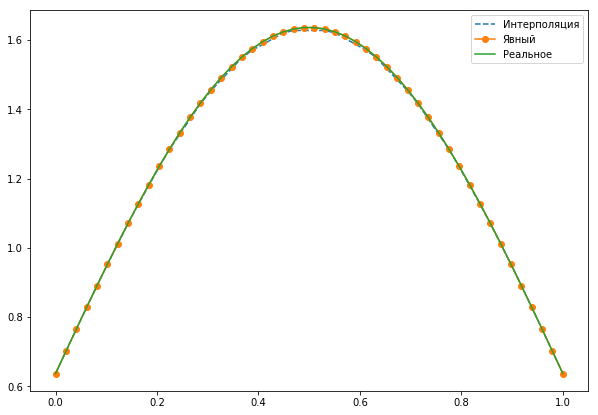

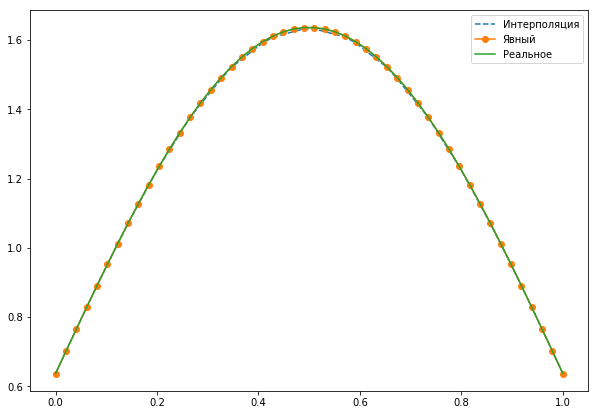

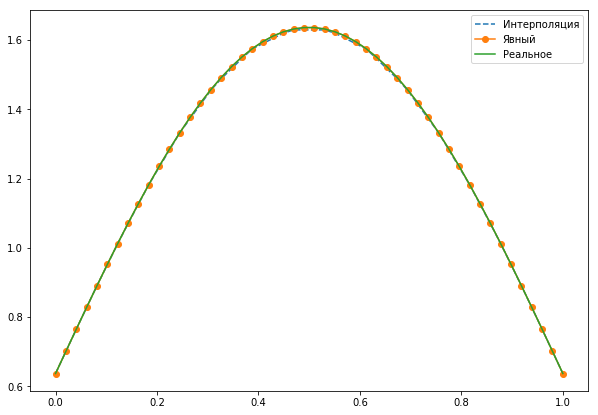

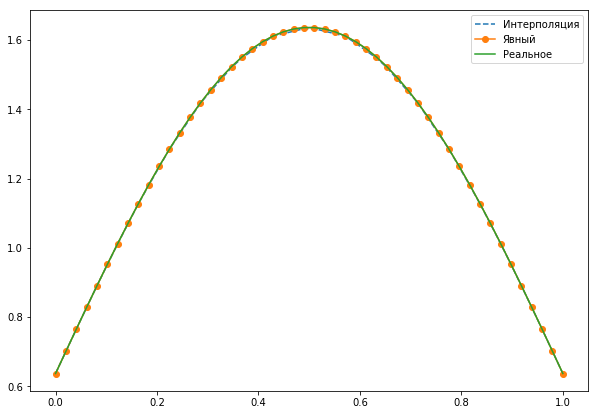

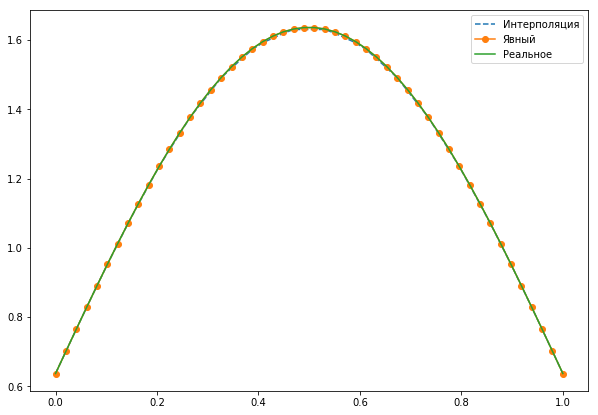

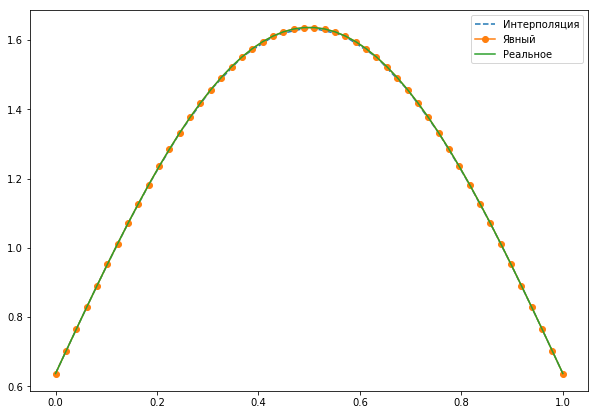

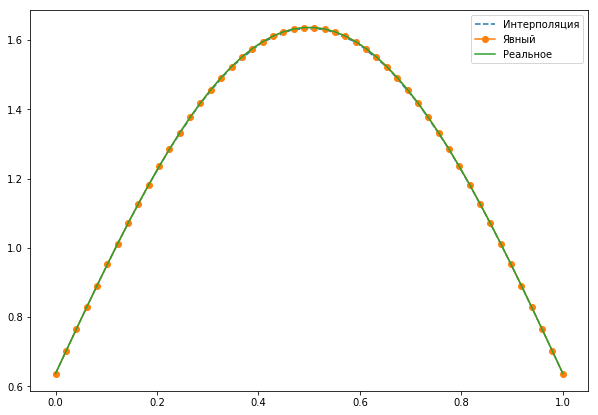

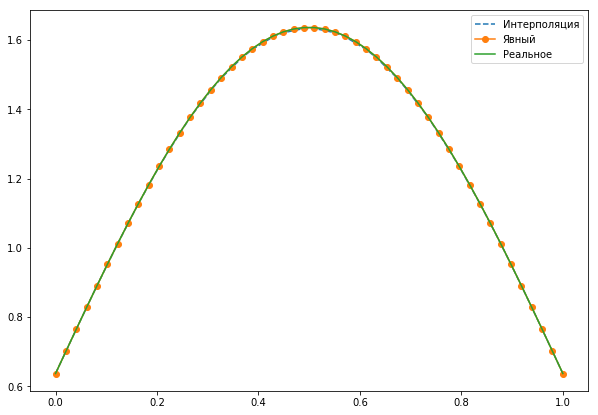

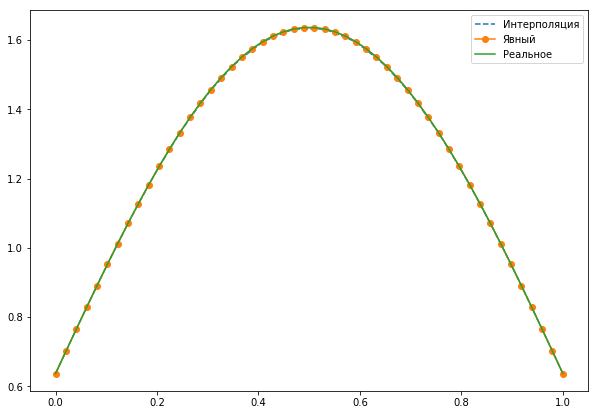

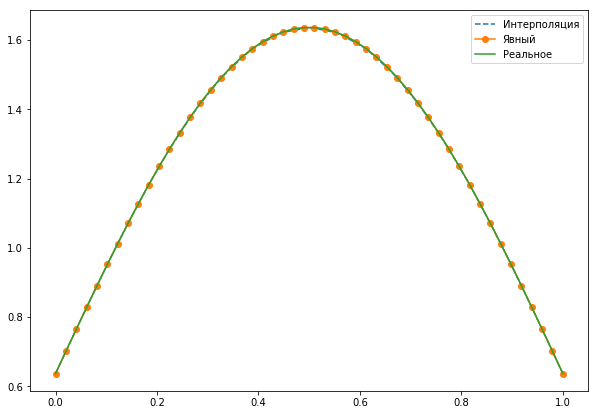

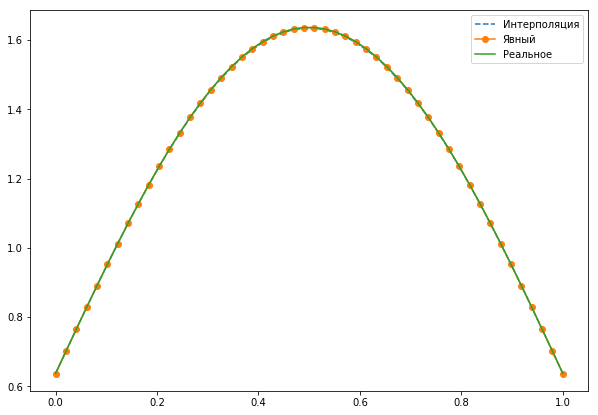

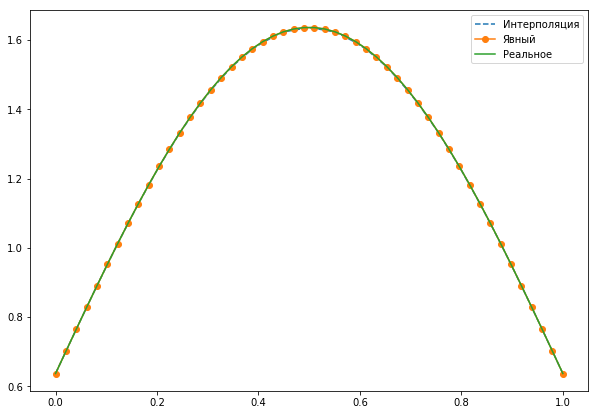

In [17]:
def g(x):
    return np.sin(np.pi * x)

def func(x, w_n, f_n):
    return g(x) + 0.5 * (w_n @ f_n)

for n in range(2, 30):
    f_n, x_n, w_n = fredholm_ex(n)
    f = interp1d(x_n, f_n, fill_value="extrapolate")
    x = np.linspace(0, 1, 50)
    plt.figure(figsize=(10, 7))
    plt.plot(x, f(x), '--', label='Интерполяция')
    plt.plot(x, func(x, w_n, f_n), 'o-', label='Явный')
    plt.plot(x, np.sin(np.pi * x) + 2 / np.pi, '-', label='Реальное')
    plt.legend(loc='best')
    plt.show()

Видно, что явный метод гораздо быстрее и лучше приближается к истине